In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
import calendar
import seaborn as sns
from functools import partial
from scipy import stats
import operator
from statsmodels.graphics.tsaplots import plot_acf

In [60]:
import warnings
warnings.filterwarnings("ignore")

#### 1. Downloading Daily Closing Prices + Closing VIX Values 

In [10]:
#LVMH, Air Liquide, CAC40, VIX
tickers = ['MC.PA', 'AI.PA', '^FCHI','^VIX']
close_data = yf.download(tickers , start = '2016-01-01',  end = '2024-12-31')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


The daily closing prices were chosen for Louis Vuitton Moët Hennessy (LVMH), Air Liquide (AI.PA) and the CAC 40 Index (^FCHI).  LVMH (MC.PA) is a multinational French holding company and conglomerate specialising in luxury goods.  Air Liquide is also a French multinational company that supplies industrial gases, technologies, and services across the healthcare, electronics, food, and automotive industries.

The CAC 40 is the French benchmark stock market index. It comprises the 40 largest and most liquid equities listed on Euronext Paris. The index is calculated and weighted using a free float-adjusted market capitalisation methodology. Each stock has a maximum weightage of 15% on the index, which is renewed quarterly.

The rationale for choosing the stock prices and index is that both corporations are within the top 10 largest companies in the CAC 40 by market capitalisation.  The CAC 40 was chosen as the index to explore how these companies’ stock prices have moved with the index – and whether or not they have impulse responses due to price/return changes in the market. Additionally, it is important to analyse whether the CBOE Volatility Index (VIX) market expectations of the S&P 500 index options index affect the CAC 40 and high-market-cap stocks on the French stock exchange.

#### 2. Creating A New DataFrame

In [14]:
df_close_data = pd.DataFrame(close_data)
df_close_data

Ticker,AI.PA,MC.PA,^FCHI,^VIX
Date,,,,
2016-01-04,55.326546,119.467705,4522.450195,20.700001
2016-01-05,54.997383,119.682289,4537.629883,19.340000
2016-01-06,54.229336,117.322098,4480.470215,20.590000
2016-01-07,52.978527,117.236275,4403.580078,24.990000
2016-01-08,52.172081,116.163483,4333.759766,27.010000
...,...,...,...,...
2024-12-23,154.240005,629.200012,7272.319824,16.780001
2024-12-24,154.339996,630.799988,7282.689941,14.270000
2024-12-26,NaN,NaN,NaN,14.730000


#### 3. Plotting Timeline

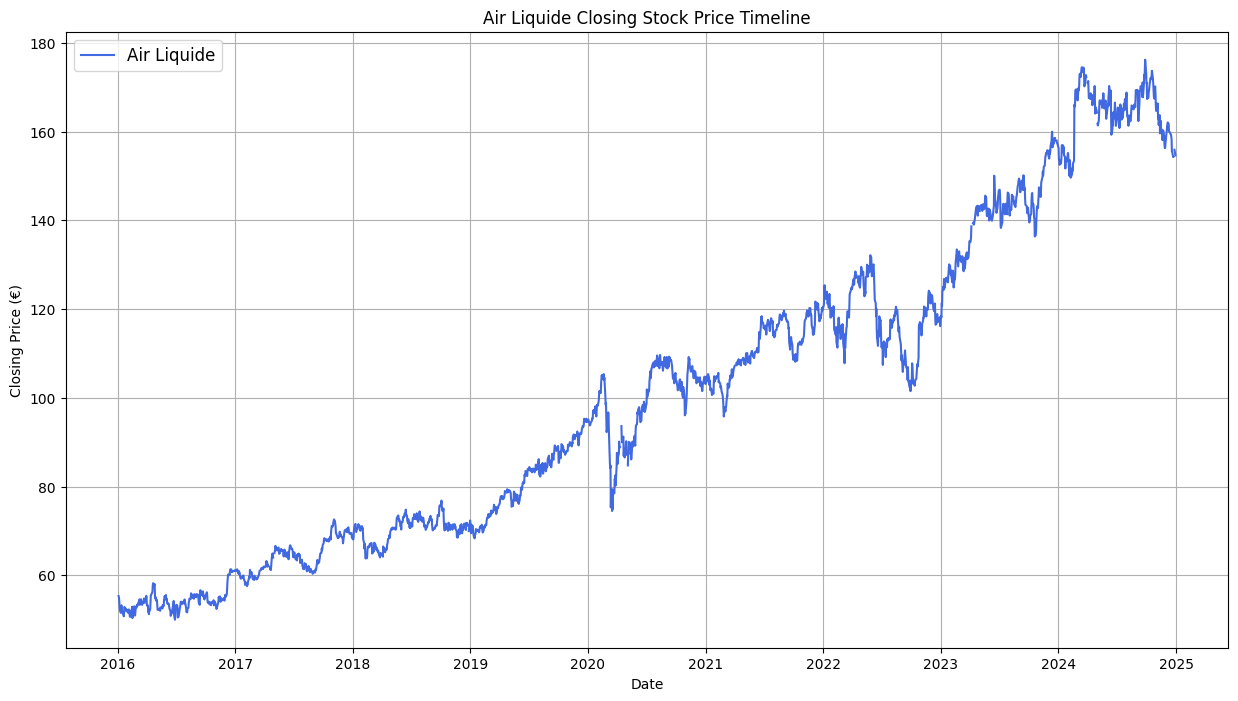

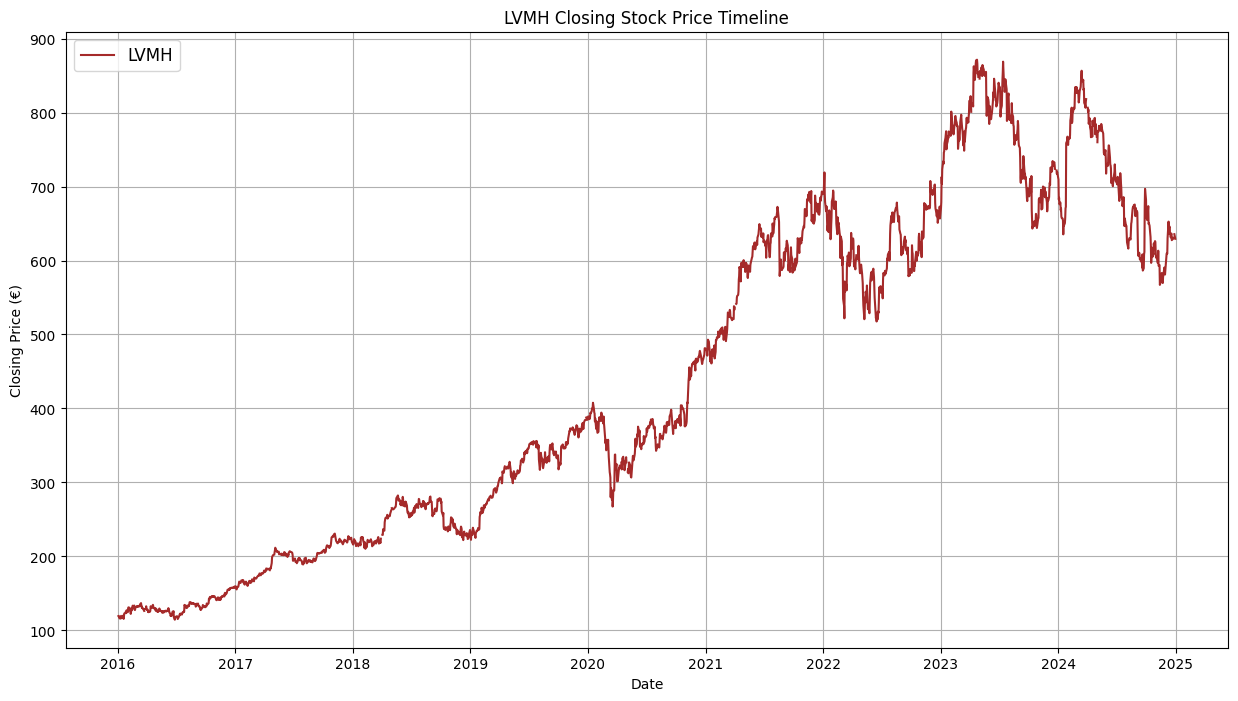

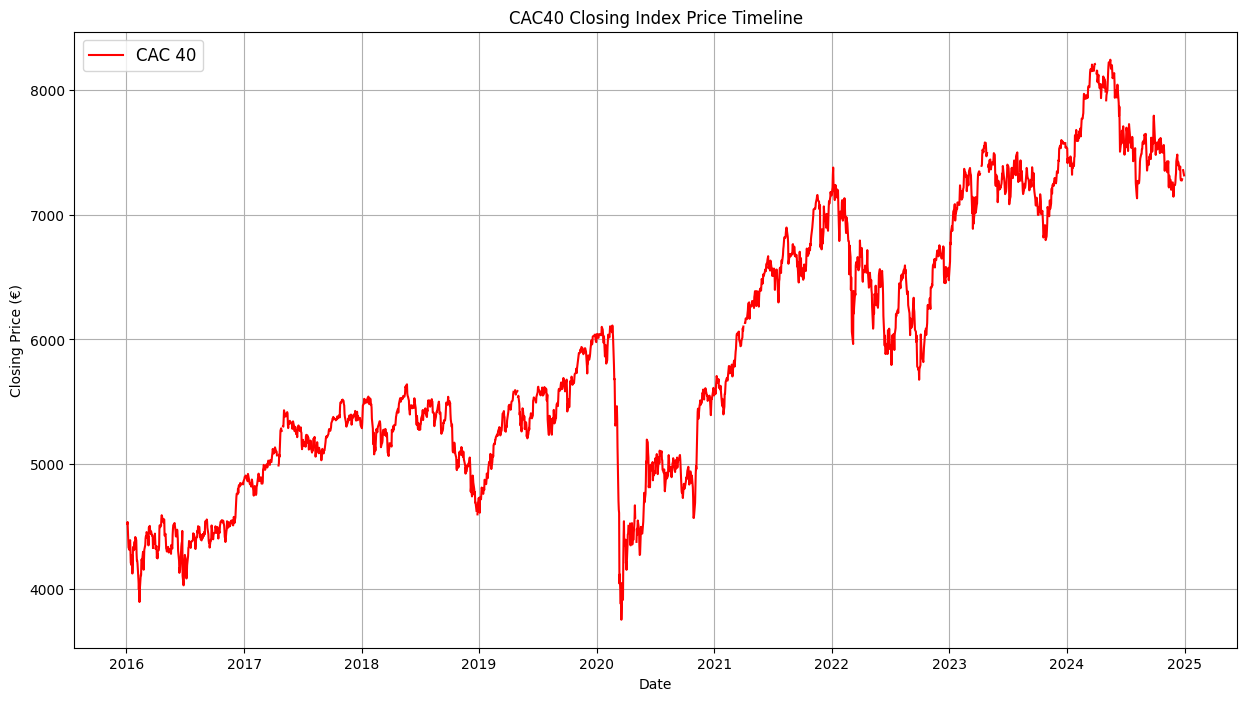

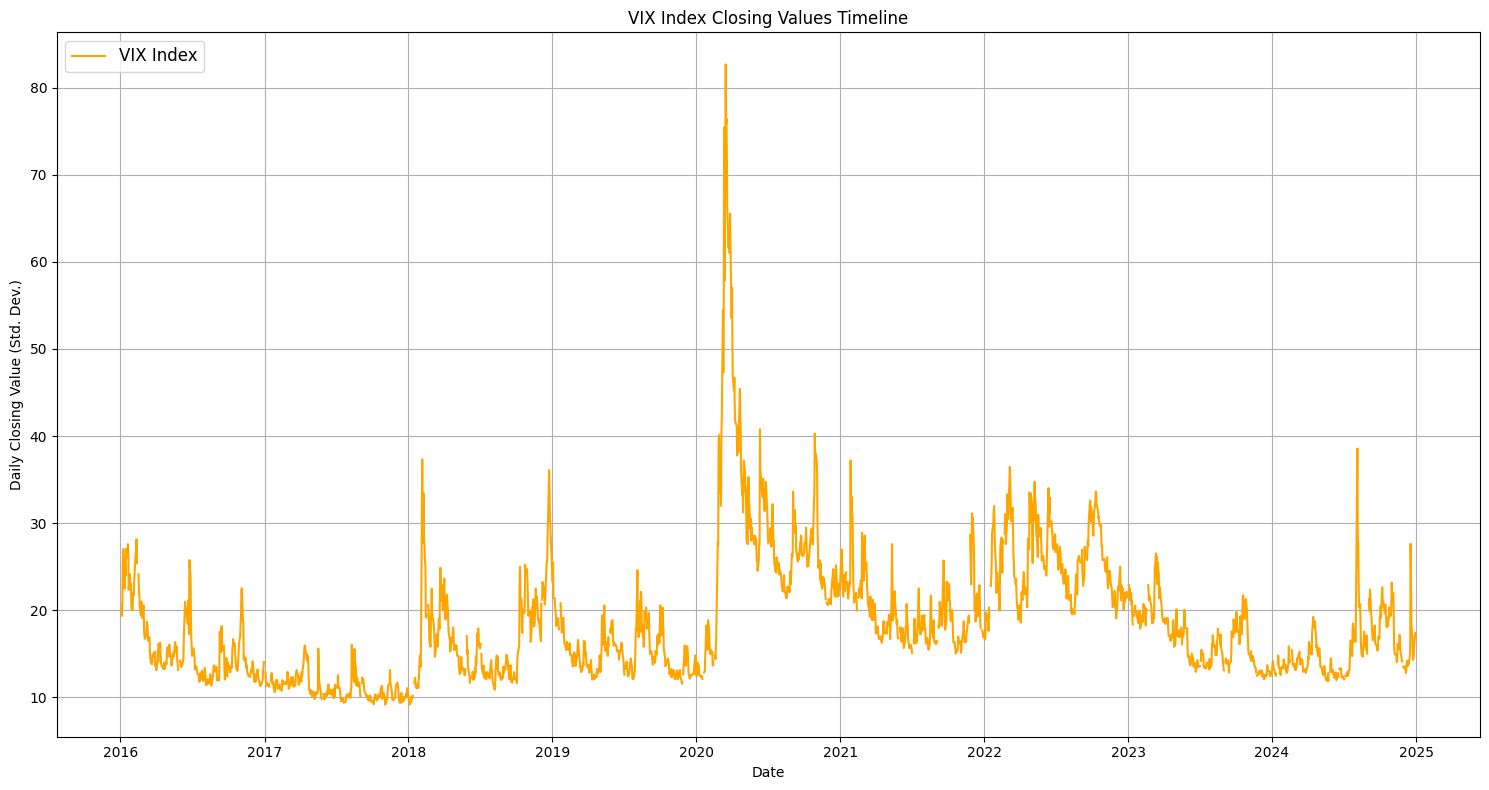

In [17]:
plot1 = plt.figure(1, figsize=(15,8), dpi = 100)
plt.title('Air Liquide Closing Stock Price Timeline')
plt.ylabel('Closing Price (€)')
plt.xlabel('Date')
plt.plot(df_close_data['AI.PA'], color = 'royalblue', label = 'Air Liquide')
plt.legend(loc = 'upper left', fontsize = '12')
plt.grid(True)

plot2 = plt.figure(2, figsize=(15,8), dpi = 100)
plt.title('LVMH Closing Stock Price Timeline')
plt.ylabel('Closing Price (€)')
plt.xlabel('Date')
plt.plot(df_close_data['MC.PA'], color = 'brown', label = 'LVMH')
plt.legend(loc = 'upper left', fontsize = '12')
plt.grid(True)

plot3 = plt.figure(3,figsize=(15,8), dpi = 100)
plt.title('CAC40 Closing Index Price Timeline')
plt.ylabel('Closing Price (€)')
plt.xlabel('Date')
plt.plot(df_close_data['^FCHI'], color = 'red', label = 'CAC 40')
plt.legend(loc = 'upper left', fontsize = '12')
plt.grid(True)

plot4 = plt.figure(4,figsize=(15,8), dpi = 100)
plt.title('VIX Index Closing Values Timeline')
plt.ylabel('Daily Closing Value (Std. Dev.)')
plt.xlabel('Date')
plt.plot(df_close_data['^VIX'], color = 'orange', label = 'VIX Index')
plt.legend(loc = 'upper left', fontsize = '12')
plt.grid(True)

plt.tight_layout()
plt.show()

The figures illustrate the closing price trends for Air Liquide, LVMH, CAC 40, and the VIX Index between 2016 and 2024 the stocks exhibit significantly different growth, fluctations, and magnitudes.

Air Liquide shows steady growth from €50 to €160 with low volatility fluctuations, except for a significant decrease in 2020 and the end of 2022, which is followed by recovery and consistent upward movement.

LVMH exhibits exponential growth from €120 to €850 by 2023, with quick volatility recovery. The stock price peaks in early 2023 and fluctuates between €650 and €850, followed by a declining stock price.

The CAC 40 index rises from €4,400 to over €8,000 by early 2024 before stabilising around €7,200.

The VIX Index highlights market volatility spikes, measured by the annualised standard deviation of the S&P 500 over the next 30 days, peaking at over 80 during the COVID-19 crisis in 2020 and showing higher periodic fluctuations thereafter.

#### 4. Saving DataFrame as CSV File

In [21]:
df_close_data.to_csv('df_close_data.csv')

#### 5. Calculation of Differenes in Variables + Inspect Head

In [24]:
df_close_data['Air_Liquide_ret'] = (df_close_data['AI.PA'].apply(np.log).diff(1))
df_close_data['LMVH_ret'] = (df_close_data['MC.PA'].apply(np.log).diff(1))
df_close_data['CAC40_ret'] = (df_close_data['^FCHI'].apply(np.log).diff(1))
df_close_data['VIX_pct_change'] = (df_close_data['^VIX'].pct_change())

In [26]:
df_close_data.info()
df_close_data = df_close_data.dropna()
df_close_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 2016-01-04 to 2024-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AI.PA            2305 non-null   float64
 1   MC.PA            2305 non-null   float64
 2   ^FCHI            2304 non-null   float64
 3   ^VIX             2263 non-null   float64
 4   Air_Liquide_ret  2284 non-null   float64
 5   LMVH_ret         2284 non-null   float64
 6   CAC40_ret        2283 non-null   float64
 7   VIX_pct_change   2324 non-null   float64
dtypes: float64(8)
memory usage: 163.5 KB


Ticker,AI.PA,MC.PA,^FCHI,^VIX,Air_Liquide_ret,LMVH_ret,CAC40_ret,VIX_pct_change
Date,,,,,,,,
2016-01-05,54.997383,119.682289,4537.629883,19.340000,-0.005967,0.001795,0.003351,-0.065701
2016-01-06,54.229336,117.322098,4480.470215,20.590000,-0.014064,-0.019918,-0.012677,0.064633
2016-01-07,52.978527,117.236275,4403.580078,24.990000,-0.023335,-0.000732,-0.017310,0.213696
2016-01-08,52.172081,116.163483,4333.759766,27.010000,-0.015339,-0.009193,-0.015982,0.080832
2016-01-11,51.546677,116.034752,4312.740234,24.299999,-0.012060,-0.001109,-0.004862,-0.100333


#### 6. Testing for Stationarity

In [29]:
# Air Liquide ADF Test
# Null Hypothesis (H0): Air Liquide time series daily returns have a unit root (non-stationary)
# H1 : Air Liquide daily returns do not have a unit root (series is stationary)

al_adfuller = adfuller((df_close_data['Air_Liquide_ret']))
print(f'Test Statistics: {format(al_adfuller[0], ".15f")}')
print(f'P-value: {format(al_adfuller[1], ".30f")}')
print(f'Critical_values: {al_adfuller[4]}')

if al_adfuller[1] > 0.05:
    print("Air Liquide series is not stationary.")
else:
    print("Air Liquide series is stationary.")

Test Statistics: -17.498610216954937
P-value: 0.000000000000000000000000000004
Critical_values: {'1%': -3.4333070451478593, '5%': -2.862846332675802, '10%': -2.5674654240037733}
Air Liquide series is stationary.


In [31]:
# LVHM ADF Test
# H0: LVMH time series daily returns have a unit root (non-stationary)
# H1 : LVMH daily returns do not have a unit root (series is stationary)


lvmh_adfuller = adfuller((df_close_data['LMVH_ret']))

print(f'Test Statistics: {format(lvmh_adfuller[0], ".15f")}')
print(f'P-value: {format(lvmh_adfuller[1], ".30f")}')
print(f'Critical_values: {lvmh_adfuller[4]}')

if lvmh_adfuller[1] > 0.05:
    print("LVMH series is not stationary.")
else:
    print("LVMH series is stationary.")

Test Statistics: -17.718564401180984
P-value: 0.000000000000000000000000000003
Critical_values: {'1%': -3.4333070451478593, '5%': -2.862846332675802, '10%': -2.5674654240037733}
LVMH series is stationary.


In [33]:
# CAC 40 ADF Test
# H0: CAC 40 time series daily returns have a unit root (non-stationary)
# H1 : CAC 40 daily returns do not have a unit root (series is stationary)

cac_adfuller = adfuller((df_close_data['CAC40_ret']))

print(f'Test Statistics: {format(cac_adfuller[0], ".15f")}')
print(f'P-value: {format(cac_adfuller[1], ".30f")}')
print(f'Critical_values: {cac_adfuller[4]}')

if cac_adfuller[1] > 0.05:
    print("CAC 40 series is not stationary.")
else:
    print("CAC 40 series is stationary.")

Test Statistics: -17.243900886493911
P-value: 0.000000000000000000000000000006
Critical_values: {'1%': -3.4333070451478593, '5%': -2.862846332675802, '10%': -2.5674654240037733}
CAC 40 series is stationary.


In [35]:
# VIX Index ADF Test
# H0: VIX  Index time series daily changes have a unit root (non-stationary)
# H1 : VIX Index daily changes do not have a unit root (series is stationary)

vix_adfuller = adfuller((df_close_data['VIX_pct_change']))
print(f'Test Statistics: {format(vix_adfuller[0], ".15f")}')
print(f'P-value: {format(vix_adfuller[1], ".30f")}')
print(f'Critical_values: {vix_adfuller[4]}')

if vix_adfuller[1] > 0.05:
    print("VIX series is not stationary.")
else:
    print("VIX series is stationary.")

Test Statistics: -19.132877175833805
P-value: 0.000000000000000000000000000000
Critical_values: {'1%': -3.4333070451478593, '5%': -2.862846332675802, '10%': -2.5674654240037733}
VIX series is stationary.


The null hypothesis of a unit root is rejected for Air Liquide, LVMH, CAC 40 returns, and the daily changes in VIX for the results of the Augmented Dickey Fuller tests, since the test statistics are substantially lower than the critical values at the significance levels. This confirms that the time series of daily returns/changes are stationary, showing that returns fluctuate around a constant mean with a stable variance. Consequently, the return series does not exhibit a persistent trend, and any deviations are mean-reverting over time.

Although periods of heightened volatility may occur, these fluctuations do not persist indefinitely and do not alter the long-term characteristics of the series. This ensures a stable autocorrelation structure, reinforcing that shocks to returns have only temporary effects. 

The rejection of the null hypothesis is additionally supported by the ADF test p-values, which are either zero or statistically insignificant, providing evidence against the presence of a unit root. This stationary implies previous returns are not an indicator in proving future trends, confirming the absence of seasonality of cyclical patterns in daily returns. 

#### 7. Creating A New Dictionary For The Variables

In [39]:
data = pd.DataFrame({'AI.PA': df_close_data['Air_Liquide_ret'],
                    'LVMH': df_close_data['LMVH_ret'],
                    'CAC 40': df_close_data['CAC40_ret'],
                    'VIX': df_close_data['VIX_pct_change']})
data

,AI.PA,LVMH,CAC 40,VIX
Date,,,,
2016-01-05,-0.005967,0.001795,0.003351,-0.065701
2016-01-06,-0.014064,-0.019918,-0.012677,0.064633
2016-01-07,-0.023335,-0.000732,-0.017310,0.213696
2016-01-08,-0.015339,-0.009193,-0.015982,0.080832
2016-01-11,-0.012060,-0.001109,-0.004862,-0.100333
...,...,...,...,...
2024-12-19,-0.017593,-0.014241,-0.012297,-0.127806
2024-12-20,-0.000772,0.000956,-0.002731,-0.237858
2024-12-23,-0.007364,0.001750,-0.000297,-0.086057


In [41]:
data.to_csv('data.csv')

#### 8. Running a Vector Autoregression [VAR] Using Returns


In [44]:
#H0 : One variable does not influence another variable over a three day period (n=3 lags)
#H1 : One variable does influence another variable over a three day period (n= 3 lags)

var_model = smt.VAR(data)
res = var_model.fit(maxlags = 3)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Apr, 2025
Time:                     02:43:24
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.6343
Nobs:                     2219.00    HQIC:                  -32.7192
Log likelihood:           23813.6    FPE:                5.87547e-15
AIC:                     -32.7680    Det(Omega_mle):     5.73978e-15
--------------------------------------------------------------------
Results for equation AI.PA
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000696         0.000264            2.639           0.008
L1.AI.PA         -0.053409         0.031271           -1.708           0.088
L1.LVMH           0.006995         0.025081            0.279           0.780

The VAR(3) model was employed to capture three-day dynamics between key components of the French stock market, French stock market index and market volatility. Given that daily returns for AI.PA, LVMH, CAC 40, and VIX are stationary, the VAR model is appropriate and will avoid making spurious correlations. Significant temporary spillover effects and bilateral interdependencies between the French market index, prominent French enterprises, and U.S. volatility (VIX) as seen in the output.

Starting with AI.PA, a 1% increase in CAC 40 at lag 1 results in a 0.065% decrease in AI.PA returns, and at lag 2, a 0.073% decrease, suggesting that AI.PA tends to react negatively to prior market gains—potentially due to its sector characteristics or market timing effects. Similarly, a 1% increase in VIX (lag 1) leads to a 0.025% drop in AI.PA, indicating sensitivity to volatility.

For LVMH, a 1% rise in VIX (lag 1) results in a 0.026% decline in returns, reflecting short-term vulnerability to rising market uncertainty. However, LVMH benefits from a broader market recovery, as a 1% increase in CAC 40 at lag 2 boosts LVMH by 0.131%, suggesting a delayed but strong positive response, possibly tied to luxury sector resilience during recovery phases.

The CAC 40 index is significantly influenced by the VIX. A 1% increase in VIX at lag 1 causes a 0.262% decrease, while lag 2 causes a 0.124% drop, emphasising the strong impact of volatility on the broader market. Additionally, a 1% rise in CAC 40 at lag 2 increases current CAC 40 returns by 0.110%, suggesting market momentum or autocorrelation.

The VIX displays notable mean reversion: a 1% increase at lag 1 and lag 2 reduces current VIX by 0.061% and 0.259%, respectively. Moreover, a 1% increase in CAC 40 at lag 2 lowers VIX by 0.082%, showing how previous market gains reduce current volatility.

#### 9. Determining The Correct Lag Order

In [48]:
lag_order = var_model.select_order(maxlags = 10)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -32.73      -32.71   6.132e-15      -32.72
1       -32.77     -32.72*   5.853e-15     -32.75*
2      -32.78*      -32.68  5.825e-15*      -32.74
3       -32.77      -32.64   5.834e-15      -32.73
4       -32.77      -32.60   5.859e-15      -32.71
5       -32.76      -32.55   5.902e-15      -32.68
6       -32.76      -32.50   5.907e-15      -32.67
7       -32.77      -32.47   5.881e-15      -32.66
8       -32.77      -32.43   5.861e-15      -32.65
9       -32.76      -32.38   5.908e-15      -32.62
10      -32.76      -32.33   5.950e-15      -32.60
--------------------------------------------------


The determination of the correct lag order in a VAR model is crucial for accurately modelling the interdependence between endogenous financial variables while ensuring that residuals remain white noise. The previous VAR (3) model assumed an appropriate lag length; however, determining the optimal lag prevents overfitting and ensures efficient estimation. The Bayesian Information Criterion (BIC) and Hannan-Quinn Criterion (HQIC) suggest a lag of 1, indicating short-term dependencies in stock and volatility dynamics. However, AIC and FPE favour a lag of 2, which captures richer market dynamics. Given the large dataset (2016–2024) and evidence that second lags significantly impact asset returns, a VAR (2) model is selected to properly account for delayed spillover effects in stock market movements and volatility transmission.

#### 10. Refitting the VAR Model with Correct Number of Lags

In [52]:
#H0 : One variable does not influence another variable over a three day period (n=2 lags)
#H1 : One variable does influence another variable over a three day period (n= 2 lags)
var_model_2 = smt.VAR(data)
result_2 = var_model_2.fit(maxlags = 2)
print(result_2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Apr, 2025
Time:                     02:43:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.6738
Nobs:                     2220.00    HQIC:                  -32.7326
Log likelihood:           23806.5    FPE:                5.88502e-15
AIC:                     -32.7664    Det(Omega_mle):     5.79055e-15
--------------------------------------------------------------------
Results for equation AI.PA
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000647         0.000263            2.461           0.014
L1.AI.PA         -0.056245         0.031259           -1.799           0.072
L1.LVMH           0.007046         0.025080            0.281           0.779

For AI.PA, CAC 40 at lag 1 (L1.CAC 40) has a significant negative impact of -0.105 (p = 0.024), indicating that a 1% increase in the CAC 40 reduces AI.PA by 0.105 percentage points. The VIX at lag 1 (L1.VIX) has a strong negative effect of -0.025 %, meaning that higher market volatility reduces AI.PA’s stock price. However, the CAC 40 at lag 2 (L2.CAC 40) has a positive effect of 0.116%, suggesting that past market trends can boost AI.PA stock over time.

For LVMH, its past value (L1.LVMH) has a negligible impact of -0.003. AI.PA at lag 1 (L1.AI.PA) negatively affects LVMH by -0.066% (P-value = 0.063), though this effect is only marginally significant. The CAC 40 at lag 2 (L2.CAC 40) has a significant positive impact of 0.093, suggesting that a 1-unit rise in the CAC 40 increases LVMH’s stock by 0.093%. The VIX at lag 1 (L1.VIX) exerts a strong negative effect of -0.025%, reinforcing that higher volatility decreases LVMH’s value.

The CAC 40 index is highly influenced by the VIX, with a strong negative effect of -0.226 at lag 1, meaning that a 1% increase in the VIX reduces the CAC 40 by 0.226 %. The index also exhibits a delayed self-effect, where L2.CAC 40 positively affects its current value by 0.114%. Additionally, the VIX at lag 2 (L2.VIX) has a negative impact of -0.007%, showing that past volatility also plays a role in weakening the market.

The VIX equation reveals that the CAC 40 at lag 2 (L2.CAC 40) has a significant negative effect of -0.918%, indicating that a strong market significantly reduces volatility. The VIX at lag 1 (L1.VIX) has a positive effect of 0.584%, demonstrating that volatility tends to persist over time.


#### 11. Plotting the Impulse Responses [Impulse Response Functions (IRF)]

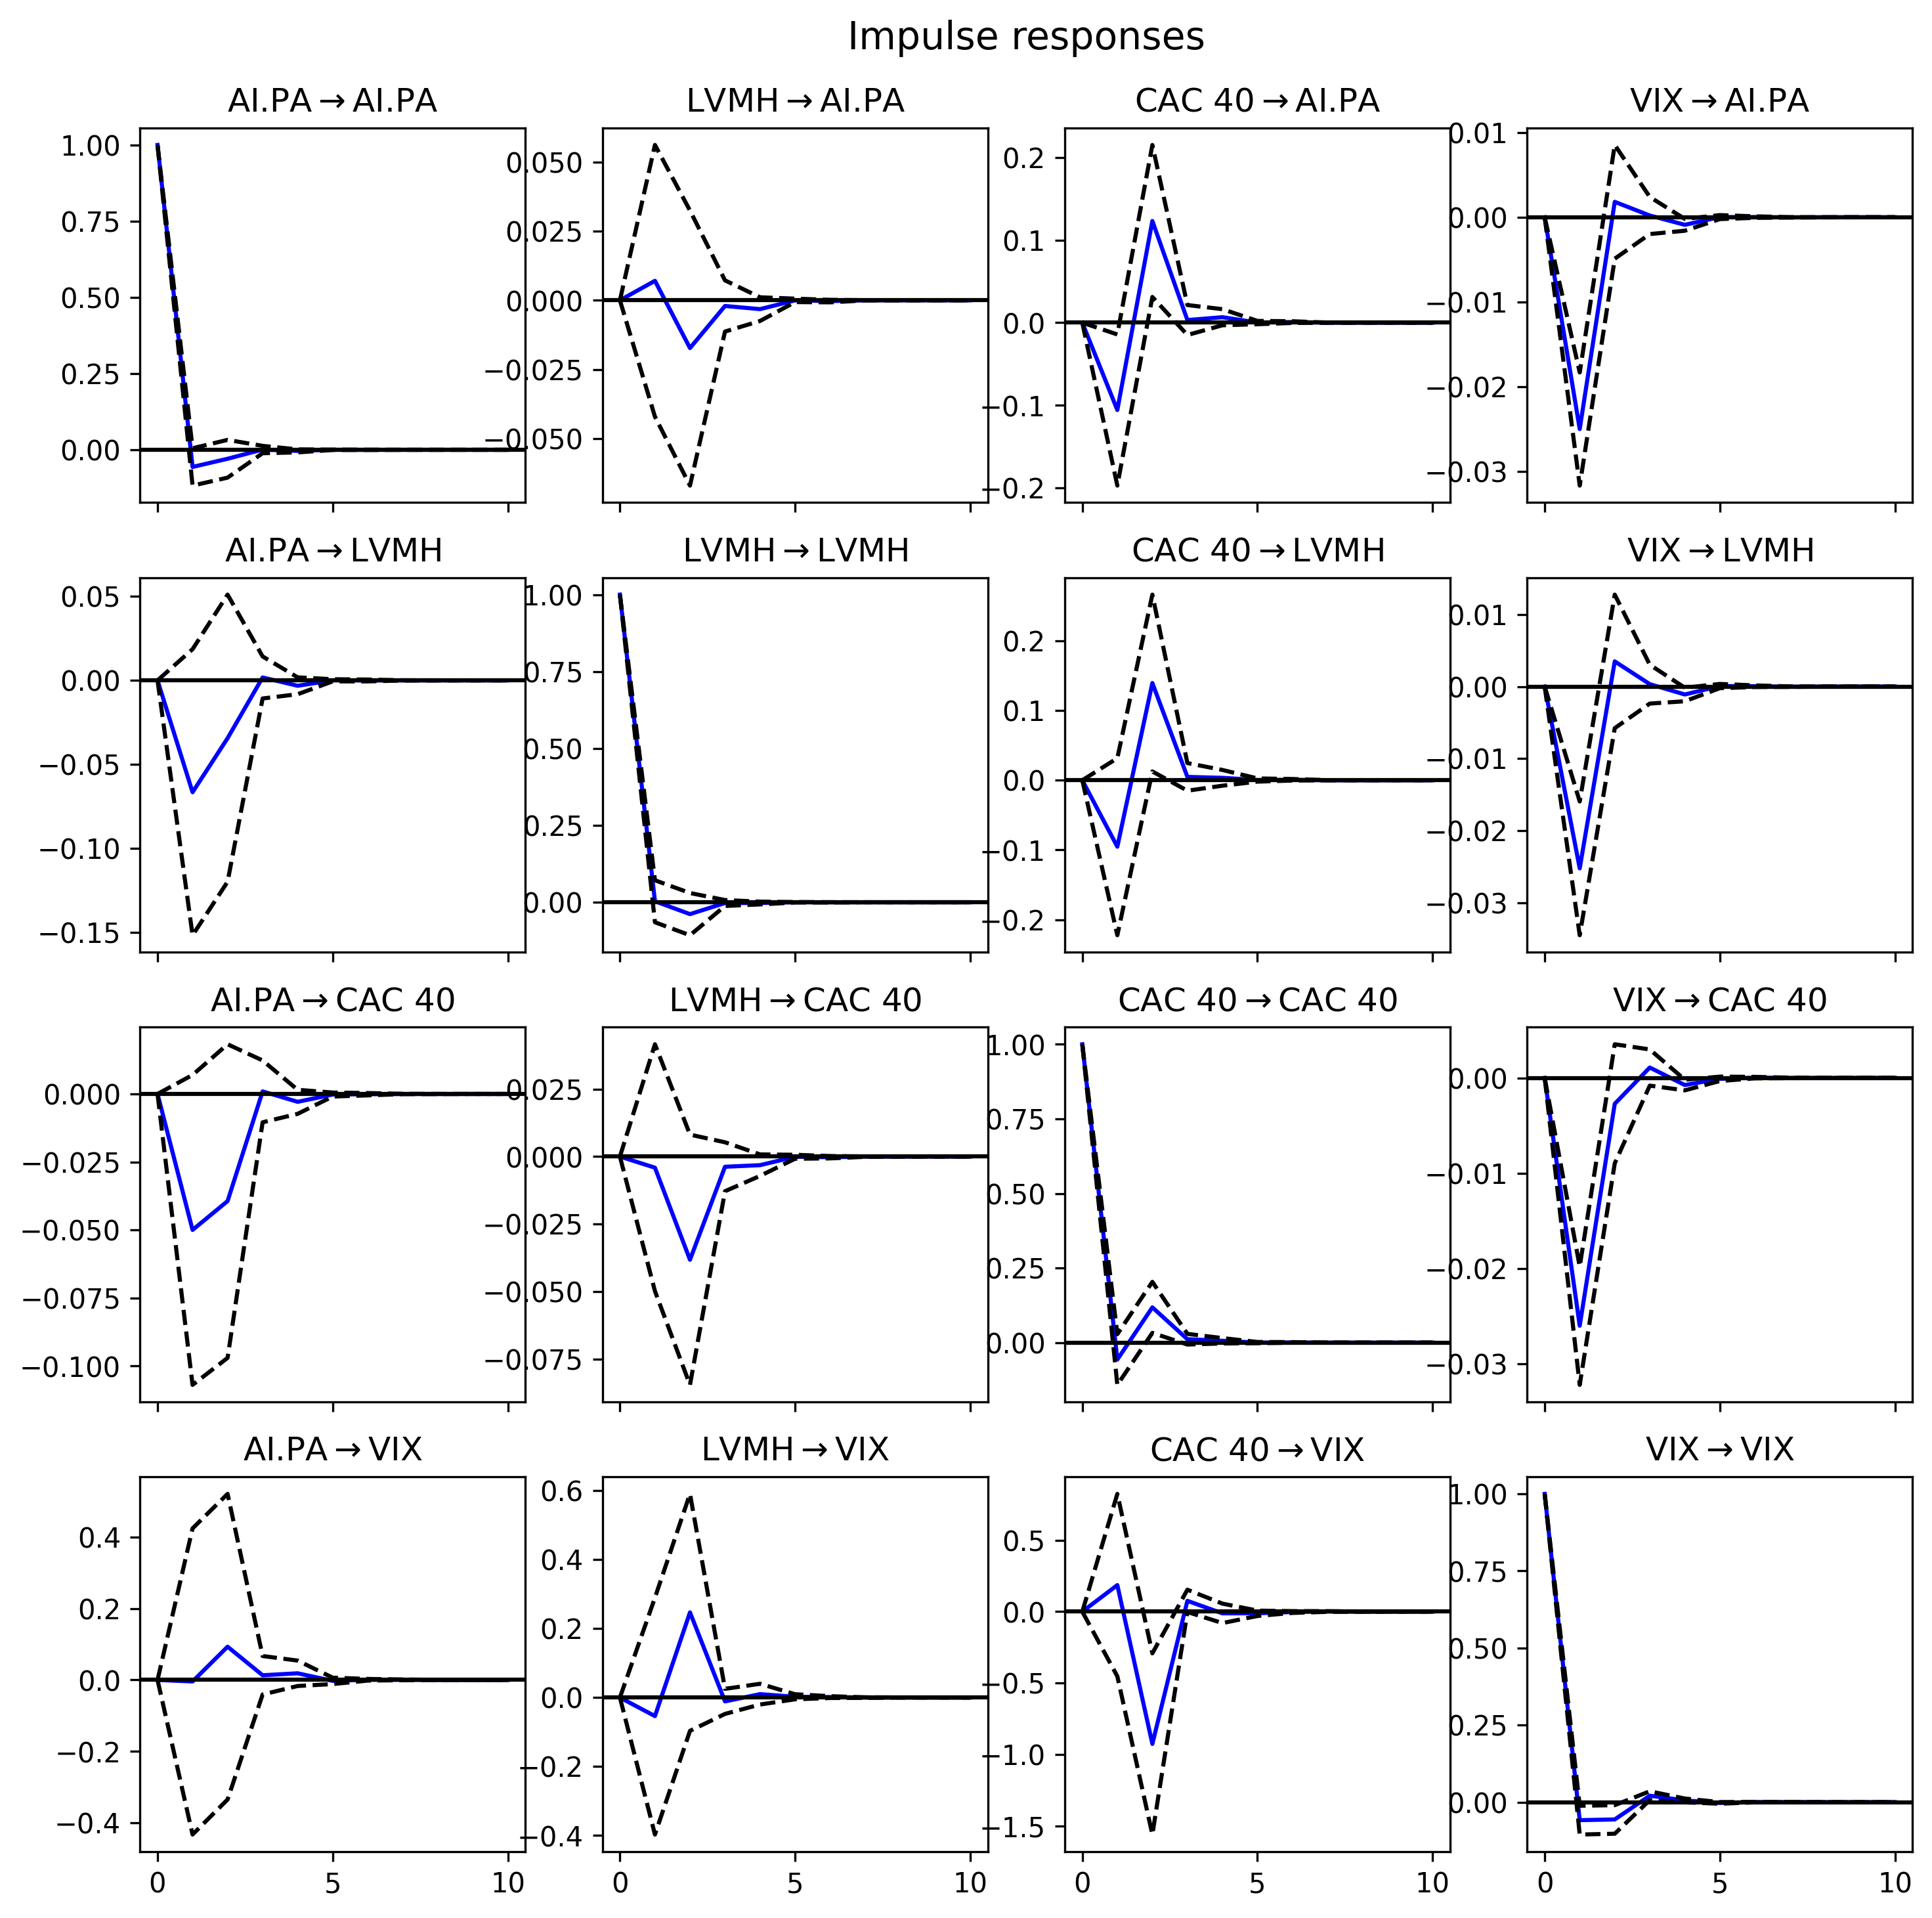

In [62]:
imp_result = result_2.irf(10)
fig = imp_result.plot()
fig.set_dpi(300)
plt.show()

Impulse Responses plotted over a 10-day period, where the vertical axis represents the magnitude of response and the horizontal axis measures the impulse responses over a ten day period. The impulse responses suggest temporary effects with shocks lasting between 5-7 days. The most significant responses are those which the confidence interval does not cross the zero line, showing the effect is statistically different from zero at a given level of confidence.

The significant impulse responses are:

1.	AI.PA -> AI.PA, where Air Liquide’s returns have a significant and immediate impact on itself, which decays over several days, indicating strong autocorrelation.

2.	CAC 40 -> AI.PA and LVMH, shocks to the CAC40 index significantly impact both Air Liquide and LVMH’s returns. This indicates that broader market movements affect the returns of its components.


3.	VIX -> AI.PA, LVMH, CAC 40, the VIX index shocks significantly affect Air Liquide, LVMH, and CAC 40 returns. This highlights market uncertainty impacts the French stock and market returns in the short run.

4.	VIX -> VIX, the VIX’s own impulse response shows strong persistence in volatility shocks which last up to 6 days showing market turbulence tends to be self reinforcing.

The VAR’s stability is critical where unstable models (eigenvalues above 1) contribute to unreliable impulse responses. It is assumed that these responses are stable and show past information affects investment. The significance responses highlight that past values of VIX and CAC 40 can move individual stock returns in the short term. 

The results signify that past information affects investment decisions, where temporary but significant shocks indicate that investors react to new information quickly, however these responses diminish over time.


#### 12. Running a Granger Causality Test

In [66]:
stable_test = result_2.is_stable()
stable_test

True

In [64]:
# H0: Y does not Granger-cause X [lags of Y do not Granger-cause X]
# H1: Y does Granger-cause X [lags of y do Granger cause X]

maxlag = 5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns)

,AI.PA_x,LVMH_x,CAC 40_x,VIX_x
AI.PA_y,1.0000,0.3019,0.0201,0.0
LVMH_y,0.0340,1.0000,0.0643,0.0
CAC 40_y,0.0351,0.2738,1.0000,0.0
VIX_y,0.0835,0.2892,0.0051,1.0


The rationale for testing Granger causality among Air Liquide, LVMH, CAC 40, and VIX is to identify predictive relationships between these financial variables. Granger causality helps determine whether past values of one variable contain information that helps predict another variable beyond what is contained in the latter's history alone. From the matrix results, there are four relationships determined through the rejection of the null hypothesis where p-value<0.05.

LVMH Granger-causes Air Liquide (p-value=0.0340) but not vice versa (p-value=0.3019), suggesting LVMH's returns contain predictive information for Air Liquide.

A significant relationship exists between Air Liquide and CAC 40 (p-values 0.0201 and 0.0351), indicating a feedback loop where each helps predict the other. AI.PA also influences CAC 40 returns, likely due to its role in the index.

VIX does not Granger-cause stock return relationships (as p-values>0.05). This signifies that daily VIX changes do not significantly predict stock returns, this suggesting weak short-term volatility spillovers.  VIX significantly Granger-causes CAC 40 (p-value=0.0051), indicating that market returns help predict future volatility.

The Granger causality test highlights the interconnectedness of French equities and suggests that market volatility has predictive power over broad market returns (CAC 40) but not individual stocks.


#### 13. Downloading Adjusted Close Values for Cryptocurrency + Differenced Log Returns + DataFrame


In [68]:
ticker_doge = ['DOGE-USD']
doge = yf.download(ticker_doge, start = '2019-01-01', end = '2024-12-31')['Close']

[*********************100%***********************]  1 of 1 completed


In [70]:
doge['DOGE_daily_ret'] = np.log(doge['DOGE-USD'] / doge['DOGE-USD'].shift(1))
df_doge= pd.DataFrame(doge.dropna())

In [72]:
print(df_doge.head())
print(df_doge.tail())

Ticker      DOGE-USD  DOGE_daily_ret
Date                                
2019-01-02  0.002407        0.006251
2019-01-03  0.002360       -0.019719
2019-01-04  0.002315       -0.019252
2019-01-05  0.002319        0.001726
2019-01-06  0.002328        0.003874
Ticker      DOGE-USD  DOGE_daily_ret
Date                                
2024-12-26  0.312256       -0.068272
2024-12-27  0.311036       -0.003915
2024-12-28  0.323919        0.040585
2024-12-29  0.314320       -0.030082
2024-12-30  0.313514       -0.002568


In [74]:
df_doge.to_csv('df_doge_data.csv')

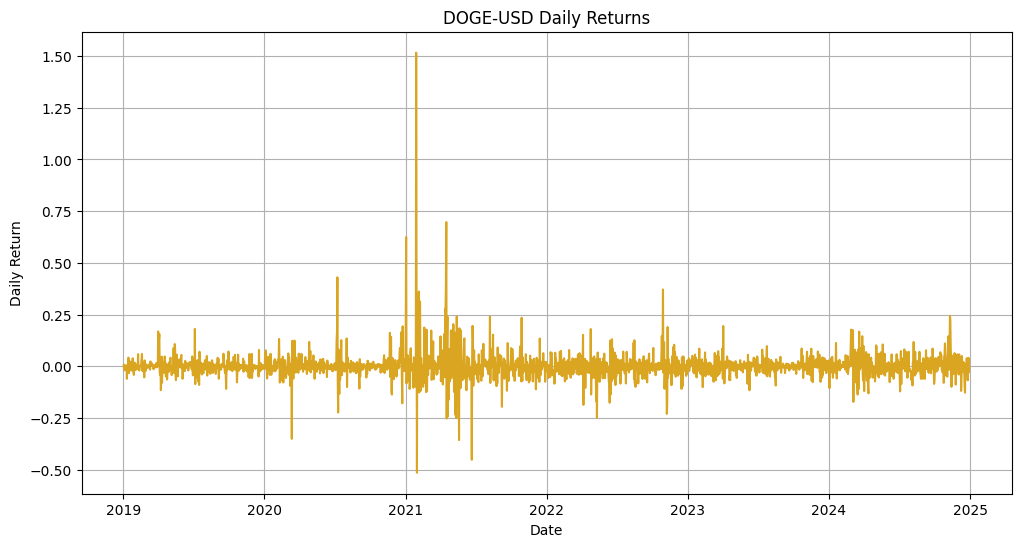

In [76]:
plt.figure(figsize = (12,6))
plt.plot(df_doge['DOGE_daily_ret'], color = 'goldenrod')
plt.title('DOGE-USD Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

Dogecoin is a unique cryptocurrency and a widely recognised digital asset, its origins started as a meme coin. Unlike other cryptocurrencies, there is no limit to the number of coins that can be mined, meaning new coins can be continuously created, thus making it inflationary. Analysing DOGE’s returns helps to understand the influence of social influence and market trends impact on non-traditional cryptocurrencies.

The Dogecoin daily return plot exhibits leptokurtosis, characterised by its fat tails and a sharper peak compared to a normal distribution. This indicates that extreme positive and negative return events occur more frequently than predicted by a normal distribution. The plot demonstrates intense volatility clustering, especially after major fluctuations. Periods of volatility pooling are followed by periods with less noise. Notice the clusters of large swings around early 2021, indicative of autocorrelation in volatility. Volatility of DOGE returns do not dissipate immediately, leading to sustained periods of uncertainty thus showing DOGE’s highly reactive and unpredictable nature.

#### 14. Volatility Modelling for DOGE Returns

In [80]:
# Saving DOGE Returns
doge_returns = df_doge['DOGE_daily_ret']
doge_returns.to_csv('doge_daily_return.csv')

##### 1. Testing for Arch Effects

In [83]:
# 1. OLS: regress doge_daily_ret on a constant
doge_data = sm.add_constant(doge_returns)
ols_results = sm.OLS(doge_returns, doge_data['const']).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:         DOGE_daily_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Apr 2025   Prob (F-statistic):                nan
Time:                        02:44:14   Log-Likelihood:                 2758.4
No. Observations:                2190   AIC:                            -5515.
Df Residuals:                    2189   BIC:                            -5509.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.517      0.1

In [85]:
#2. ARCH Model
# H0: There are no ARCH effects in residuals (residuals have constant variance over time)
# H1: There are ARCH effects in residuals (error terms), homoscedastic, and no time-dependent patterns exist.
residuals = ols_results.resid

res = het_arch(residuals, nlags = 5)
name = ['LM Statistic', 'LM P-value', 'F-Statistic', 'F-Statistic P-value']
lzip(name,res)

[('LM Statistic', 43.40763854738762),
 ('LM P-value', 3.05474348079637e-08),
 ('F-Statistic', 8.833169756974813),
 ('F-Statistic P-value', 2.5981116476022703e-08)]

##### 2. Modelling Volatility with the GARCH (1,1) Model

In [88]:
# 1. Fitting in the GARCH (1,1) Model

# H0: There are no GARCH effects in the residuals (constant volatility over time)- α = 0 and  and β = 0
# H1: Volatility is time-dependent (Volatility follows a GARCH process) - α > 0 and β > 0

garch_m = arch_model(doge_returns, p = 1, q = 1, vol = 'GARCH', dist = 'normal')
garch_m_result = garch_m.fit()
print(garch_m_result .summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2086756127.8207755
Iteration:      2,   Func. Count:     17,   Neg. LLF: 48495804.3577344
Iteration:      3,   Func. Count:     27,   Neg. LLF: -3331.976372166686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3331.9763408855933
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         DOGE_daily_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3331.98
Distribution:                  Normal   AIC:                          -6655.95
Method:            Maximum Likelihood   BIC:                          -6633.19
                                        No. Observations:                 2190
Date:                

In [90]:
# 2. Calculating GARCH (1,1) Residuals
garch_model_residuals = garch_m_result.resid
gm_volatility = garch_m_result.conditional_volatility
gm_std_resid = garch_model_residuals /gm_volatility

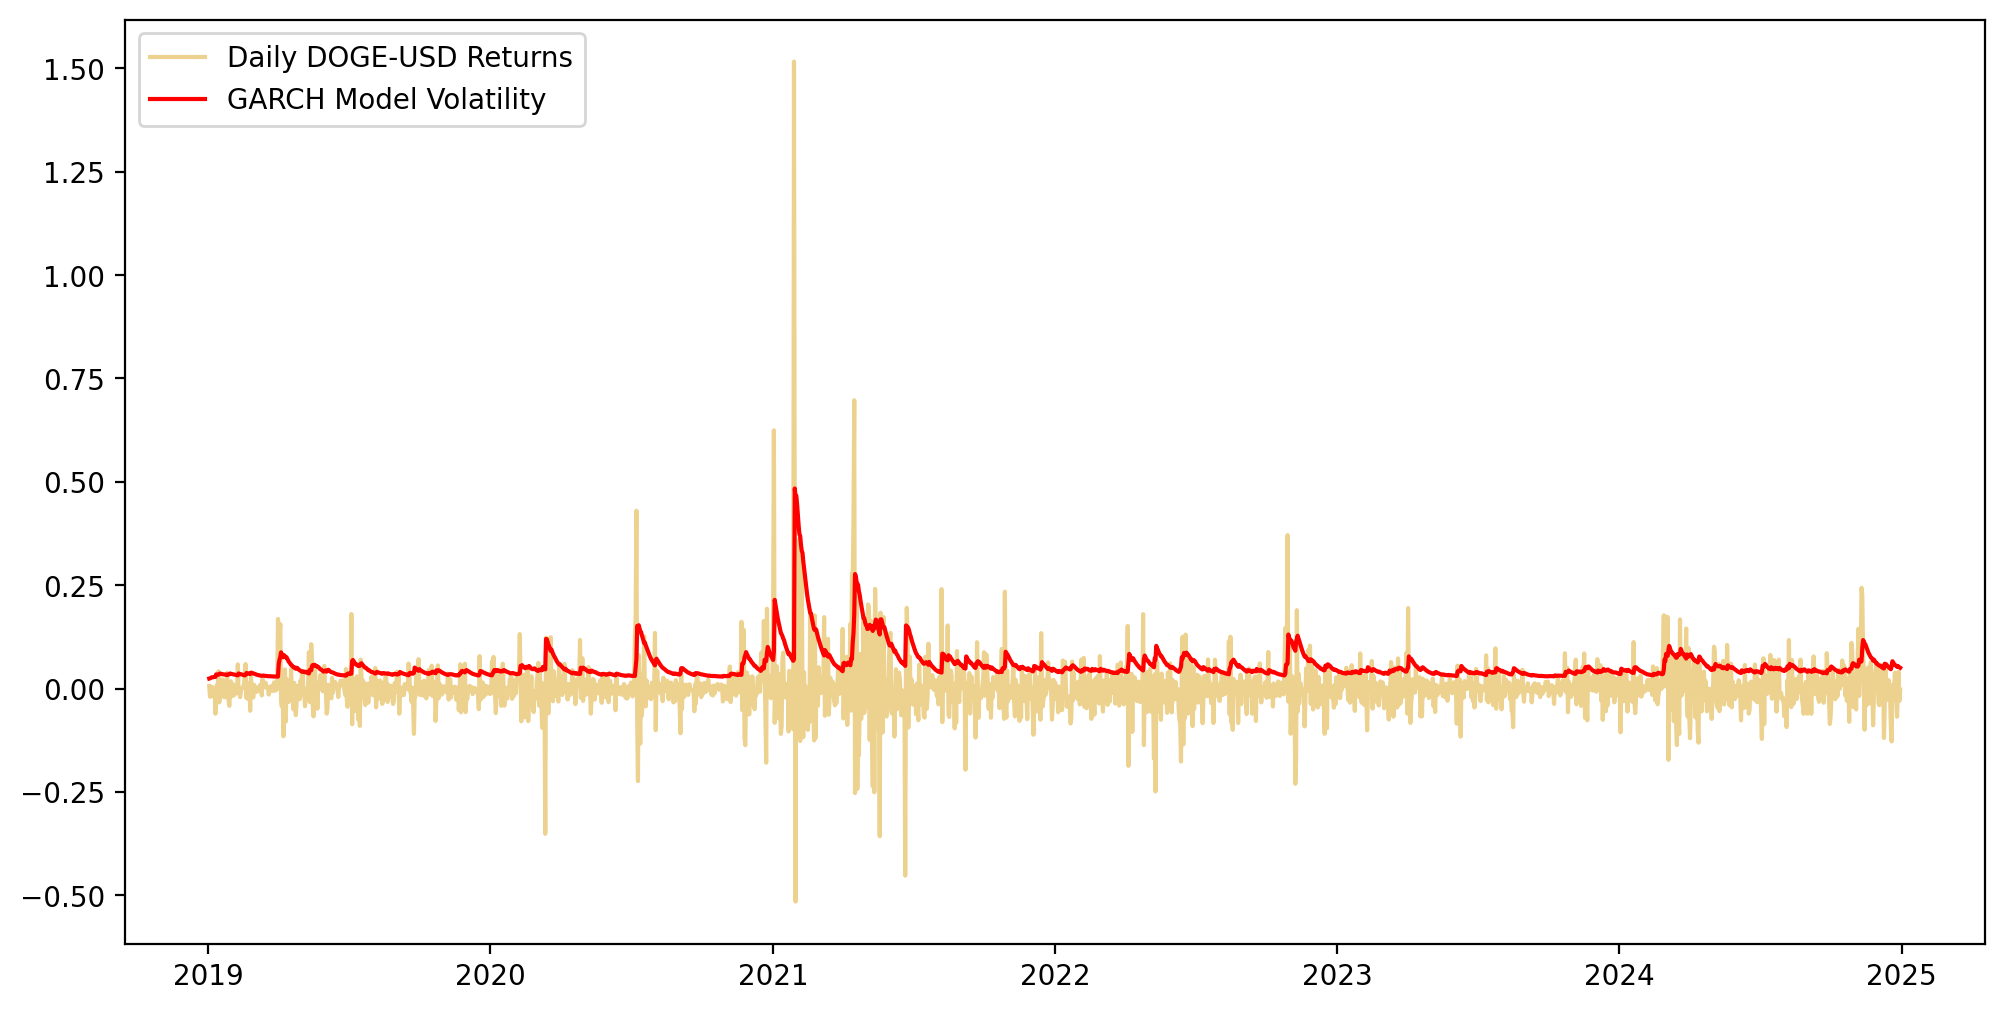

In [92]:
#3. DOGE-USD Daily Returns Against GARCH Model Volatility
plot = plt.figure(figsize = (12,6), dpi = 200)
plt.plot(doge_returns, color = 'goldenrod', alpha = 0.5, label = 'Daily DOGE-USD Returns')
plt.plot(gm_volatility, color = 'red', label = 'GARCH Model Volatility', )
plt.legend(loc = 'upper left')
plt.show()

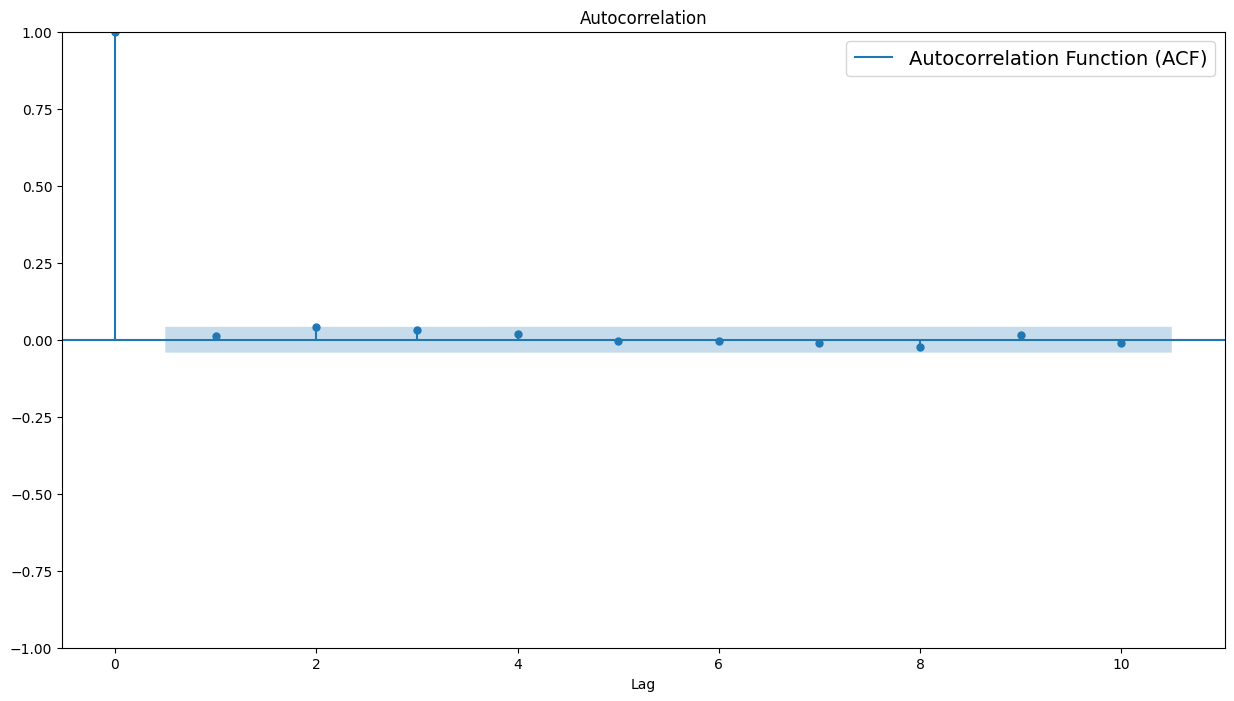

In [93]:
#4. Testing Validity of GARCH Model [Autocorrelation in Standardised Residuals?-]
plt.rc('figure', figsize = (15,8))
plot_acf(gm_std_resid, alpha = 0.05, lags = 10)
plt.xlabel('Lag')
plt.legend(['Autocorrelation Function (ACF)'], loc = 'upper right', fontsize = '14')
plt.show()

To model the volatility of DOGE-USD returns, this must first be assessed through the presence of heteroskedasticity and the suitability of the GARCH (1,1) framework.
The OLS regression is carried out to test its residuals for ARCH effects. This model assumes homoscedasticity residuals (a constant variance). However, the results showed an R-squared of 0, indicating the model has no explanatory power.  The constant term was statistically insignificant, and the JB test confirmed that the residuals are not normally distributed. 

To test for heteroskedasticity, ARCH effects are tested, where the null hypothesis assumes no homoscedasticity (no ARCH effects), and the alternative suggests that volatility depends on past residuals. The results provide strong evidence against the null hypothesis (LM statistic 43.41, p-value = 3.05e-08) and F-statistic (8.83, p-value = 2.59e-08). This confirmed the presence of ARCH effects, demonstrating that the variance of returns is not constant but evolves. Given these findings, a GARCH model was necessary to capture the dynamics of volatility fully.

A GARCH (1,1) model was applied, which allows for a linear mean equation while modelling non-linear variance through autoregressive conditional heteroskedasticity. The results showed that the GARCH term β was statistically significant, indicating that past volatility strongly influences future volatility, creating persistent volatility clustering. In contrast, the ARCH term α was not significant, suggesting that individual shocks to returns do not have a major short-term impact on variance. This pattern aligns with typical financial time series behaviour, where volatility is more dependent on long-term trends rather than immediate fluctuations.

The GARCH model is plotted against the DOGE-USD returns, showing that it captures the structure of the volatility well, especially in periods hf higher volatility, particularly around 2021.  The magnitude of the volatility may not capture the full extent of the fluctuations.

Furthermore, the ACF indicates the absence of significant autocorrelation beyond lag 1 is a positive sign, suggesting that the GARCH (1,1) model adequately captures conditional heteroskedasticity in DOGE-USD returns. 


#### 15. Modelling Seasonality for the CAC 40 Index

##### 1. Calculations [Weekday Return / Mean]

In [99]:
cac_40 = yf.download('^FCHI', start = '2005-01-01',  end = '2024-12-31')['Close']

[*********************100%***********************]  1 of 1 completed


In [101]:
cac_40_ret = cac_40.pct_change()
cac_40_ret = pd.DataFrame(cac_40_ret.dropna())

In [103]:
cac_40_ret['Weekday'] = cac_40_ret.index.weekday.values
cac_40_ret['Weekday'] = cac_40_ret['Weekday'].apply(lambda x: calendar.day_name[x])

In [105]:
cac_40_ret.to_csv('cac_40_weekday_ret.csv')

In [107]:
cac_40_ret= cac_40_ret['2006' : '2019']
cac_40_weekday_mean = cac_40_ret.groupby('Weekday').mean()
cac_40_weekday_mean= cac_40_weekday_mean.reindex(['Monday', 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday'])

##### 2. Visualising Weekday Returns

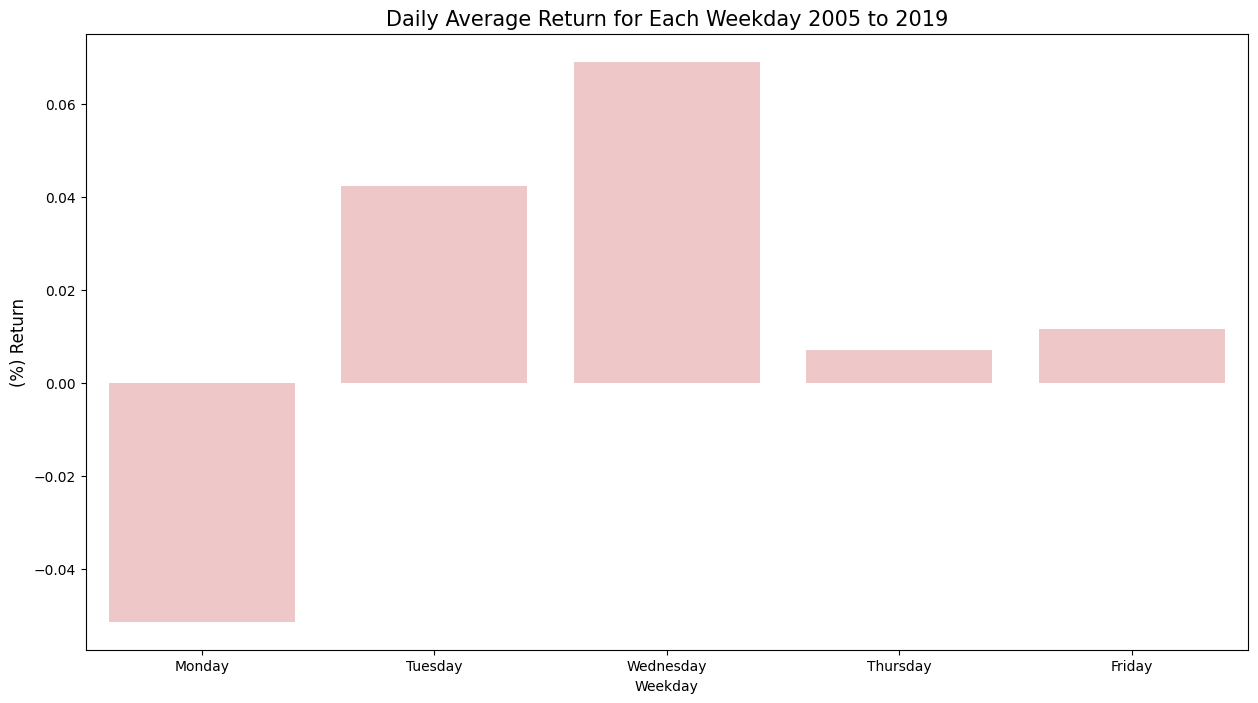

In [110]:
#1 Boxplot
x= cac_40_ret['Weekday']
y = 100*cac_40_weekday_mean['^FCHI']

sns.set_palette(['#F4C2C2'])
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=cac_40_weekday_mean.index, y = y, data= cac_40_weekday_mean)
ax = plt.ylabel('(%) Return', size = 12)
ax = plt.title('Daily Average Return for Each Weekday 2005 to 2019', size = 15)
plt.show()

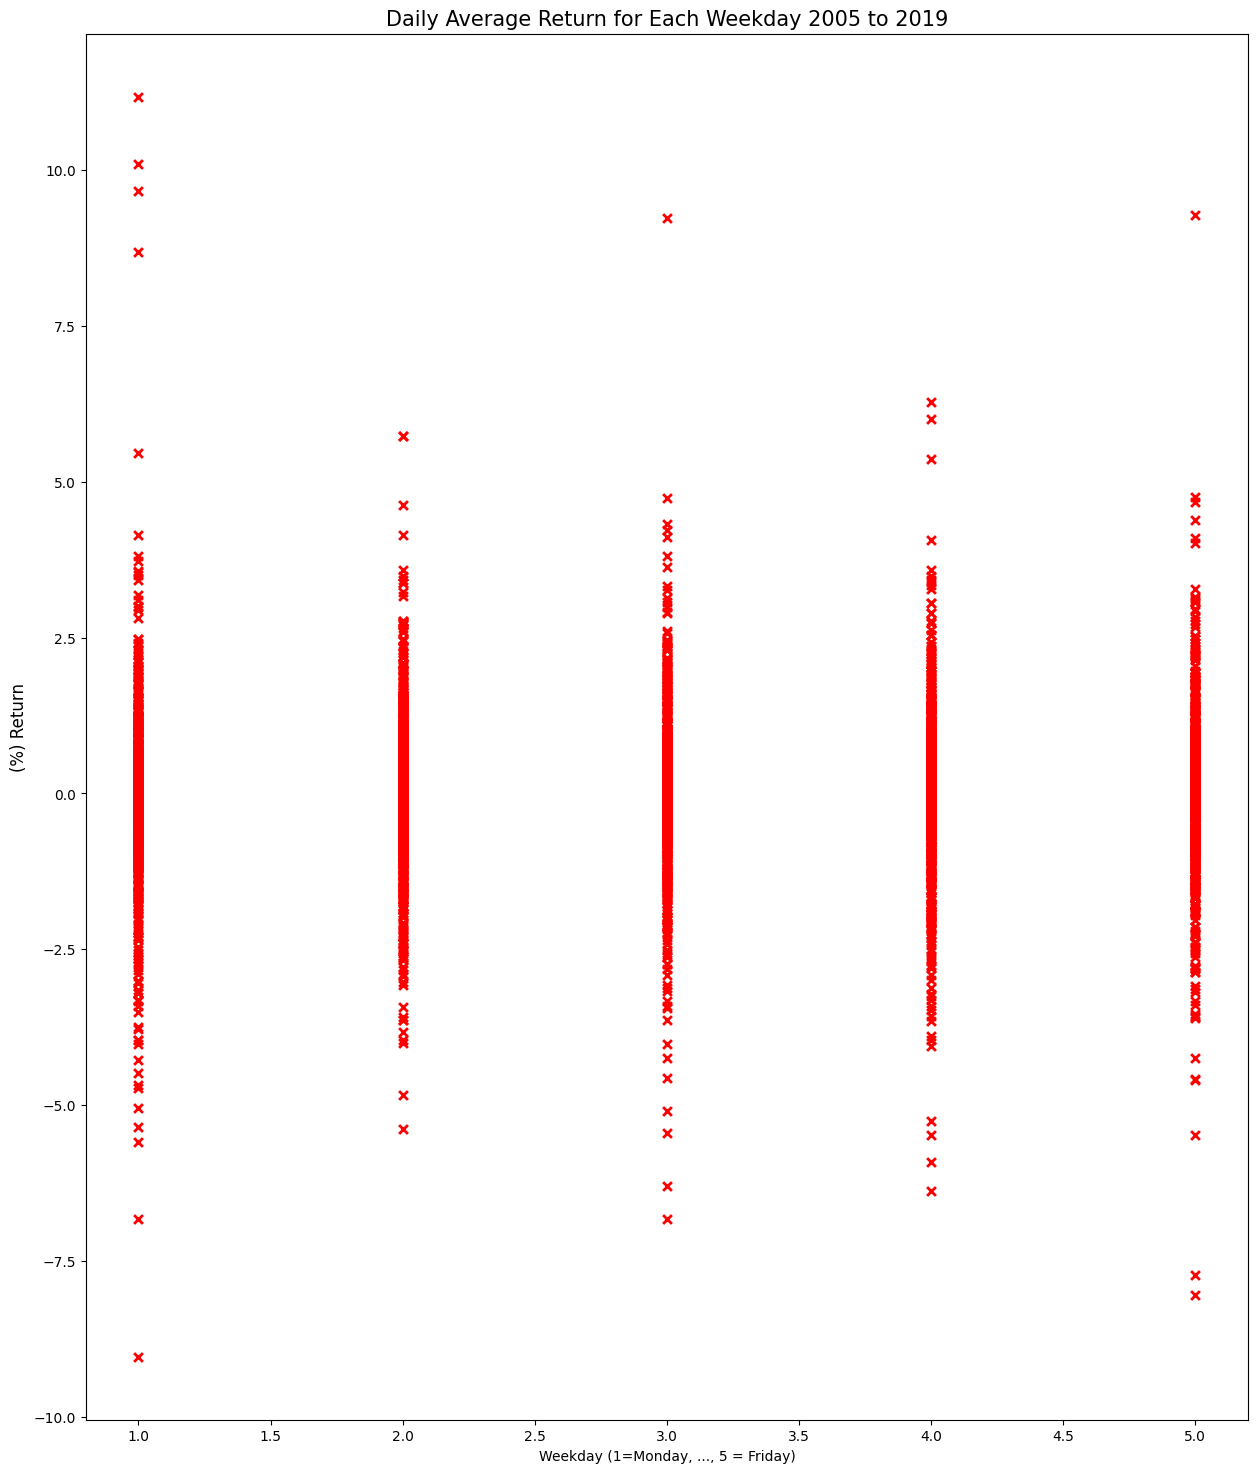

In [112]:
#2 Scatter plot
map_days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5}
x = cac_40_ret['Weekday'].map(map_days)
y = 100 * cac_40_ret['^FCHI']

plt.figure(figsize=(15,18))
plt.scatter(x,y, color = 'red', linewidths = 2, marker = 'x', s = 40)
plt.xlabel('Weekday (1=Monday, ..., 5 = Friday)')
plt.ylabel('(%) Return', size = 12)
plt.title('Daily Average Return for Each Weekday 2005 to 2019', size = 15)
plt.show()

##### 3. Estimating Volatility and Number of Observations for Each Weekday

In [115]:
# Estimating Volatility + Number of Observations for Each Weekday

volatility_weekday = cac_40_ret[['Weekday', '^FCHI']].groupby('Weekday').std()
print(volatility_weekday)
print(cac_40_ret[['Weekday', '^FCHI']].groupby('Weekday').count())

Ticker        ^FCHI
Weekday            
Friday     0.013677
Monday     0.015406
Thursday   0.013215
Tuesday    0.012816
Wednesday  0.013089
Ticker     ^FCHI
Weekday         
Friday       706
Monday       706
Thursday     721
Tuesday      720
Wednesday    722


##### 5. T-Test

In [118]:
# H0: The mean for all weekdays (μᵢ) is equal to the average return over all days (grand mean)
# [H0: μᵢ = Grand mean]

# H1: The mean for all weekdays is not equal to the average return over all days
# [H1: μᵢ ≠ Grand mean]

average_return = cac_40_weekday_mean['^FCHI'].mean()
ttest_func = partial(stats.ttest_1samp, popmean=average_return)
ttest_results = cac_40_ret.groupby('Weekday')['^FCHI'].apply(ttest_func)
result_df = pd.DataFrame.from_records(map(operator.methodcaller('_asdict'), ttest_results), index=ttest_results.index)
result_df['df'] = cac_40_ret.groupby('Weekday')['^FCHI'].count() - 1
formatted_results = ("t-statistic: " + result_df['statistic'].round(2).astype(str) +
                     ", p-value: " + result_df['pvalue'].round(4).astype(str) +
                     ", degrees of freedom: " + result_df['df'].astype(str))
pd.set_option('display.max_colwidth', None)
print(formatted_results)


# DISCUSS THE RESULTS. we are interested in p values.
# Also, the greater the magnitude of T, the greater the evidence against the null hypothesis. This means there is 
# greater evidence that there is a significant difference. The closer T is to 0, the more likely there isn't a 
# significant difference.

Weekday
Friday       t-statistic: -0.08, p-value: 0.9375, degrees of freedom: 705
Monday       t-statistic: -1.16, p-value: 0.2476, degrees of freedom: 705
Thursday     t-statistic: -0.18, p-value: 0.8589, degrees of freedom: 720
Tuesday       t-statistic: 0.56, p-value: 0.5787, degrees of freedom: 719
Wednesday      t-statistic: 1.1, p-value: 0.2738, degrees of freedom: 721
dtype: object


##### 6. Comparing Weekdays Between Each Year

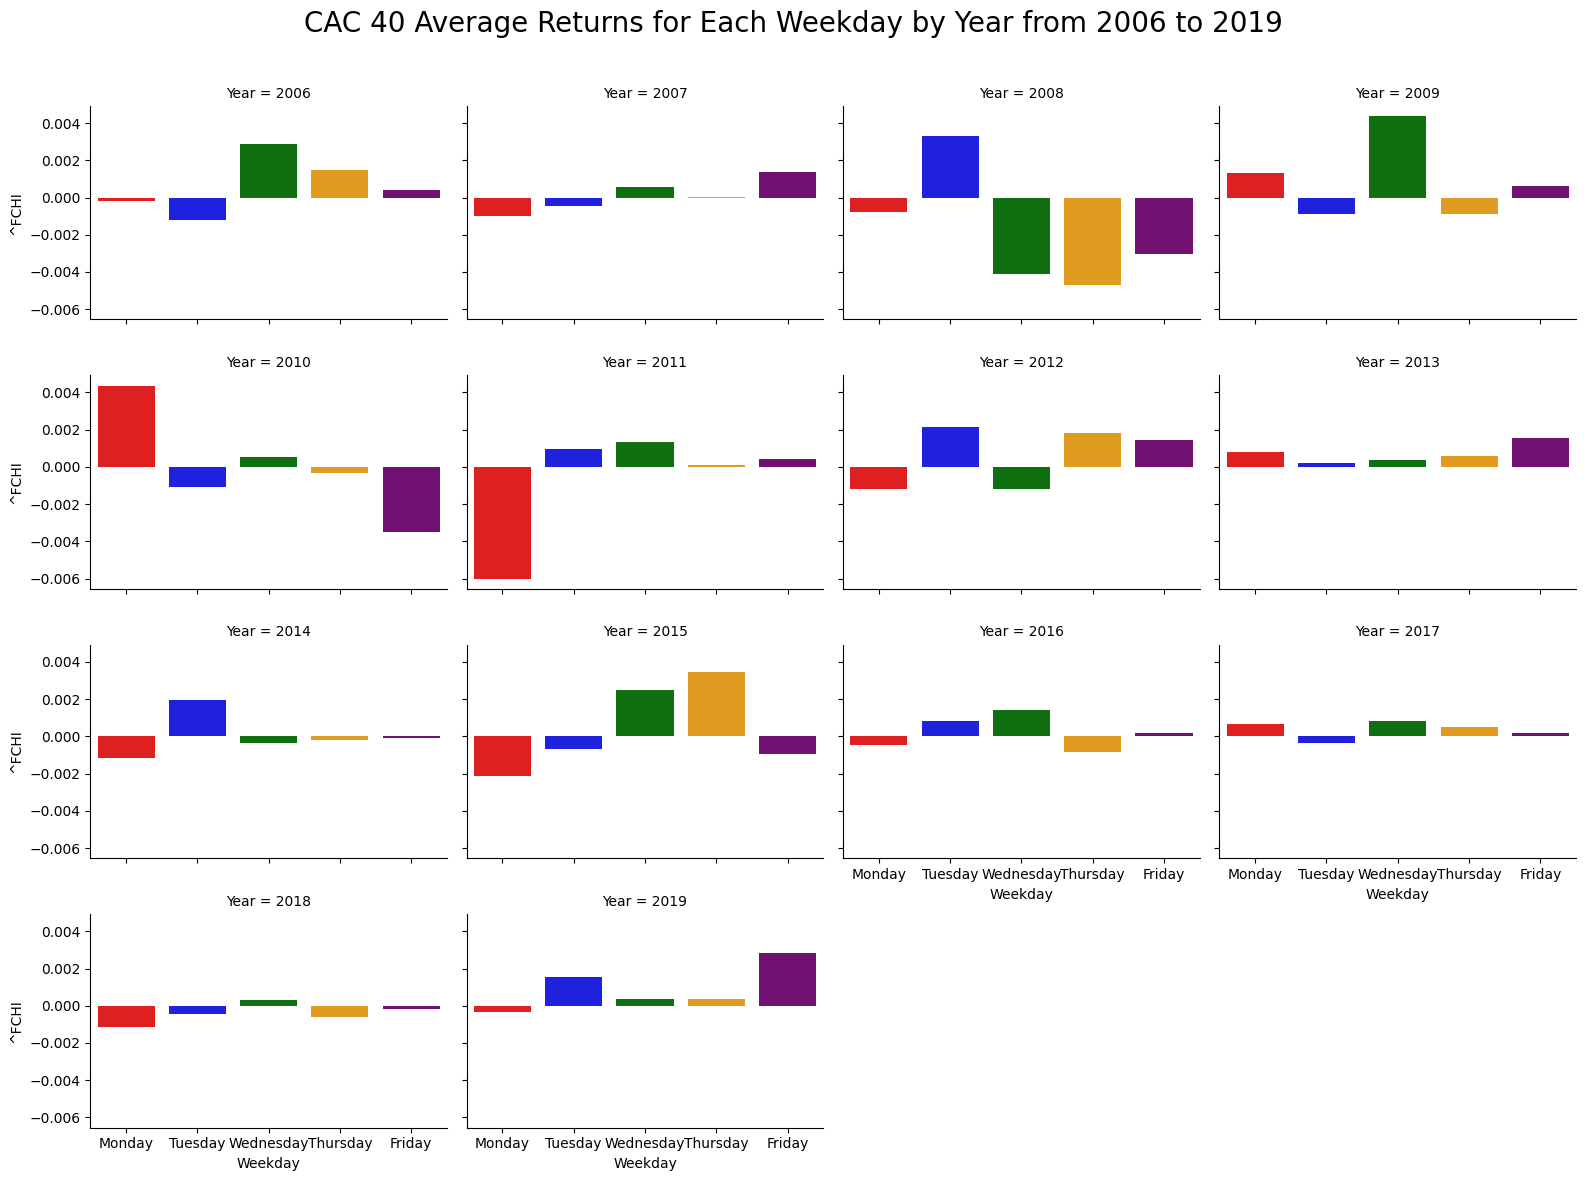

In [121]:
cac_40_ret['Year'] = cac_40_ret.index.year
cac_40_mean = cac_40_ret.groupby(['Year', 'Weekday'], as_index=False).mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
cac_40_mean['Weekday'] = pd.Categorical(cac_40_mean['Weekday'], categories=weekday_order, ordered=True)

palette = {
    'Monday': 'red', 
    'Tuesday': 'blue', 
    'Wednesday': 'green', 
    'Thursday': 'orange', 
    'Friday': 'purple'
}

g = sns.catplot(
    data=cac_40_mean,
    x="Weekday",
    y="^FCHI",
    hue="Weekday",
    kind="bar",
    palette=palette,
    col="Year",
    col_wrap=4,        
    height=3,
    aspect=1.33
)

g.fig.suptitle('CAC 40 Average Returns for Each Weekday by Year from 2006 to 2019', fontsize = 20)
plt.tight_layout()
g.fig.subplots_adjust(top=0.90)
plt.show()

The analysis of CAC 40 returns from 2006 to 2019 uncovers distinct weekday patterns, as visually represented and statistically tested. 

The bar chart shows evidence of a ‘Monday Effect’, in which Monday exhibits a negative average return below 0.04%. This implies that the market may be adversely affected at the beginning of the week by variables that have accumulated over the weekend, such as delayed responses to world news or investor sentiments. Tuesdays and Wednesdays demonstrate positive average returns, reaching around 0.04% and 0.07%, indicating a mid-week rise. These returns could be explained by the market's adjustment after the initial Monday dip or specific market adjustments that promote growth mid-week. Thursdays and Fridays show relatively stable returns, hovering slightly above 0%, suggesting that the market stabilizes or experiences a minor uptrend toward the week's conclusion. 

The scatter plot reinforces these average return levels and illustrates the distribution of daily returns across each weekday, identifying potential outliers that deviate significantly from the norm. 

The volatility data, with standard deviations ranging from 0.013677 on Monday to 0.015406 on Tuesday, indicates the level of risk associated with each day; the consistent spread of returns across all weekdays is confirmed by the fact that the number of observations only changes slightly each day. However, the t-test results, while showing different t-statistics for each day, ultimately indicate that none of the weekdays have mean returns that are statistically significantly different from the overall average return, given the high p-values (ranging from 0.2476 to 0.9375).

The chart illustrates the average weekday returns of the CAC 40 index from 2006 to 2019, revealing notable patterns across different market conditions. Mondays frequently show negative or minimal returns, particularly during crisis years like 2008, 2010, and 2011, aligning with the well-documented "Monday Effect" where markets react to weekend uncertainty. Tuesdays and Wednesdays generally exhibit stronger performance, especially in years following downturns, such as 2009 and 2015, suggesting midweek optimism or favourable economic updates. Thursdays often vary but tend to be more volatile in crisis periods. Friday returns are mixed—flat or negative in turbulent years like 2008 and 2010, but more positive in stable periods like 2012, 2013, and, notably, 2019, possibly reflecting end-of-week portfolio adjustments or optimism heading into the weekend. Over time, especially from 2013 onward, weekday return differences appear less pronounced, indicating a stabilizing market with lower volatility. This shift suggests that while weekday return effects exist, their strength and consistency fluctuate with broader economic conditions and investor sentiment.